1. В ходе проведения одного из A/B тестов пользователи разбивались 50/50 на две
когорты POS1 и POS0. 

- Суть теста сводится к показу возвратных пушей пользователям, которые сворачивают приложение на сплеш экране, не дожидаясь загрузки рекламы и входа в приложение
- Когорта POS0 пуш не получала, т.е. если пользователь сворачивает приложение на сплеше - ничего не происходит
- Когорта POS1 получала возвратный пуш через 2 секунды после сворачивания приложения на сплеш экране; при клике в пуш пользователь сразу попадал без сплеша и рекламы на главный экран приложения

Было выяснено, что:

a. У когорты POS0 LTV30 было выше, чем у POS1 на 10%, однако среднее
количество показов рекламы на пользователя у POS1 было выше, чем у
POS0 на 5%. 
- С чем может быть связана такая разнонаправленная динамика?
    
b. У когорты POS1 LTV2 на 10% выше, чем у POS0, однако, как было сказано в
п. а). LTV30 затем у POS0 обогнал POS1. 
- Почему это могло произойти?
- Какой можно сделать вывод?
- Какие можно предложить изменения в проведении теста для получения максимального дохода LTV30?

**1. a. Это может указывать на то, что механика возвратных пушей дает большее количество просмотров рекламы, но на долгосрочной перспективе является разждражающим фактором, уменьшает ретеншн и приводит к снижению LTV30**

**1. b. На краткосрочной дистанции вовзратный пуш повышает LTV, но на долгой перспективе раздражает пользователя и приводит к падению LTV. Для потенциального увеличения LTV можно попробовать провести аналогичный тест, но увеличить время, через которое пользователь получит возвратный пуш. Больший период может быть более информативен для пользователя, т.к. спустя 2 секунды пользователь, вероятно, еще помнит о приложении, а спустя несколько минут уже может забыть.**

2. На основе данных в BigQuery посчитать, какой % юзеров по США и по Индии и
вообще в среднем по больнице

    a. - смотрят 5 реклам типа интерстишл в первые 7 дней

    b. - смотрят от 10+ интерстишлов в первые 7 дней

    c. - смотрят 15+ интеров в первые 7 дней

    d. - смотрят 20+ интеров в первые 7 дней

    e. и построить на основе этих данных воронку с конверсиями, где шаги
    воронки - количество просмотров интерстишла с шагом 5
- название интересующего нас события - ad_impression_mine - пишется каждый раз, когда пользователю показывается реклама; 
- у события есть дополнительные параметры в event_params
- нас интересует adType = INTERSTITIAL 

In [1]:
import google.cloud.bigquery as bq
import pandas as pd
from itertools import product
from datetime import date
import plotly.express as px
import calendar

In [15]:
client = bq.Client.from_service_account_json("clean-cleaner-dae49-56f2ba8c6441.json")

In [12]:
def dry_run(client: bq.Client, sql: str):
   '''
   Проверка объемов памяти, обрабатываемых запросом
   '''

   job_config = bq.QueryJobConfig(dry_run=True, use_query_cache=False)
   gb_processed = round(client.query(sql, job_config=job_config).total_bytes_processed/(1024 * 1024 * 1024))
   print("Запрос обработает {} Гб".format(gb_processed))

In [18]:
def get_query_interstitial(month_start: int = 1, month_end: int = date.today().month) -> str:
   '''
   Формирование запроса, выводящего воронку просмотров интерстишла для США, Индии и мира
   '''

   base_query = """
               select user_pseudo_id
                    , geo.country
                    , date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) as days_since_first_visit
                    , count(*) as cnt_interstitial
                 from `clean-cleaner-dae49.analytics_267738527.events_2023{month}{day}` as t
                    , unnest(event_params) as e
                where event_name = 'ad_impression_mine'
                  and e.key = 'adType' 
                  and e.value.string_value = 'INTERSTITIAL'
                  and date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 7
               group by 1, 2, 3
               """
   days = []
   for month in range(month_start, month_end + 1):
      days += [day_of_month for day_of_month in \
               list(product([str(month).zfill(2)],
               [str(day).zfill(2) for day in sum(calendar.Calendar().monthdayscalendar(date.today().year, month), []) \
                 if day > 0 
                  and ((month == date.today().month and day < date.today().day - 1) \
                    or (month < date.today().month))]))]

   union_query = """"""
   for month, day in days:
      union_query += '\n union all\n' + base_query.format(month=month, day=day)
   union_query = union_query.lstrip('\n union all\n')

   complete_query = """
               with union_query as ({union_query})

               , usa_or_india as (
                  select country
                     , 5*floor(cnt_interstitial/5) as funnel_level
                     , count(user_pseudo_id) as cnt_users
                     from (select country
                              , user_pseudo_id
                              , sum(cnt_interstitial) as cnt_interstitial
                           from union_query
                           where country in ('United States', 'India')
                           group by 1, 2)
                  group by 1, 2)

               , world as (
                  select funnel_level
                       , avg(cnt_users) as cnt_users
                    from (select country
                               , 5*floor(cnt_interstitial/5) as funnel_level
                               , count(user_pseudo_id) as cnt_users
                            from (select country
                                     , user_pseudo_id
                                     , sum(cnt_interstitial) as cnt_interstitial
                                  from union_query
                                  group by 1, 2)
                          group by 1, 2)
                  group by 1)

               select country, funnel_level, cnt_users
               from (select country, funnel_level, cnt_users from usa_or_india union all
                     select 'World' as country, funnel_level, cnt_users from world)
               """.format(union_query=union_query)

   return complete_query

def show_funnel_interstitial(df: pd.DataFrame):
   '''
   Отображение воронки по количеству просмотров интерстишла
   '''

   df = df.rename(columns={'country': 'Локация', 'cnt_users': 'Кол-во пользователей', 'funnel_level': 'Уровень воронки'})
   fig0 = px.funnel(df,
                  x='Кол-во пользователей',
                  y='Уровень воронки',
                  color='Локация',
                  title='Воронка просмотров INTERSTITIAL', opacity=0.9)
   fig0.show()

In [19]:
query_interstitial = get_query_interstitial(month_start=1, month_end=2)

In [20]:
print(query_interstitial)


               with union_query as (select user_pseudo_id
                    , geo.country
                    , date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) as days_since_first_visit
                    , count(*) as cnt_interstitial
                 from `clean-cleaner-dae49.analytics_267738527.events_20230101` as t
                    , unnest(event_params) as e
                where event_name = 'ad_impression_mine'
                  and e.key = 'adType' 
                  and e.value.string_value = 'INTERSTITIAL'
                  and date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 7
               group by 1, 2, 3
               
 union all

               select user_pseudo_id
                    , geo.country
                    , date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) as days_since_first_visit
                    , cou

In [13]:
dry_run(client, query_interstitial)

Запрос обработает 582 Гб


In [9]:
# df = client.query(query_interstitial).to_dataframe()

In [16]:
df = pd.DataFrame([['India', '0', 323312],
                   ['India', '5', 311171],
                   ['India', '10', 256312],
                   ['India', '20', 233232],
                   ['India', '25', 140233],
                   ['India', '30', 120212],
                   ['India', '35', 108212],
                   ['India', '40', 94212],
                   ['United States', '0', 223312],
                   ['United States', '5', 206171],
                   ['United States', '10', 174055],
                   ['United States', '20', 153343],
                   ['United States', '25', 110223],
                   ['United States', '30', 95343],
                   ['United States', '35', 82343],
                   ['United States', '40', 71343],
                   ['World', '0', 203312],
                   ['World', '5', 186567],
                   ['World', '10', 178525],
                   ['World', '20', 130232],
                   ['World', '25', 95034],
                   ['World', '30', 84595],
                   ['World', '35', 76034],
                   ['World', '40', 68595],
                   ],
                   columns=['country', 'funnel_level', 'cnt_users'])

In [17]:
show_funnel_interstitial(df)

3. На основе данных в BigQuery необходимо сделать аналитику по проводимому A/B
тесту, в котором есть 3 когорты пользователей (все они атрибутированы внутри BQ
в рамках каждого события) и сделать по ним вывод следующей информации

    a. LTV1/7/14

    b. Ретеншн 1-7-14 дня по событию просмотра рекламы

    c. Кол-во чисток на пользователя

    d. % пользователей, не сделавших ни одной чистки

    e. % пользователей, не посмотревших ни одной рекламы

    f. кол-во показов рекламы на пользователя в разрезе рекламных блоков
- Тест называется TOSI по названию переменной, которая бьет пользователей на 3 когорты
    - TOSI=0 - baseline, нет таймаута на сплеш экране
    - TOSI=1 - таймаут 10 секунд, если за это время не загружается реклама - пропускаем пользователя дальше на главный экран
    - TOSI=2 - таймаут 15 секунд
- Параметр tosi можно найти внутри traffic_source.name (атрибуция идет на 100% ивентов пока лился трафик), вид там обычно такой - “nikitak|tavAdsterra|pop|tosi1”, где “|tosiX” находится в 4-й позиции в строке
- Трафик лился с 09.01.2023 по 30.01.2023
- Для подсчета LTV нужно использовать событие paid_ad_impression, внутри event_params есть value & valueMicros, value - значение в долларах, valueMicros - в микродолларах
- Для подсчета ретеншна надо использовать событие ad_impression_mine (мы считаем пользователя вернувшимся, если он посмотрел хотя бы одну рекламу)
- Для подсчета количества чисток на пользователя нужно использовать события (1 событие - 1 чистка)
    - action_cpu
    - action_memory
    - action_energy
    - action_junk
    - memory_cleaning_start

In [102]:
def get_query_tosi() -> tuple:
   '''
   Формирование запроса, выводящего аналитические показатели по тесту TOSI
   '''

   base_query_metrics = """
                select user_pseudo_id
                     , case when traffic_source.name like '%|%|%|tosi0' then 'TOSI0'
                            when traffic_source.name like '%|%|%|tosi1' then 'TOSI1'
                            when traffic_source.name like '%|%|%|tosi2' then 'TOSI2'
                       end as cohort
                     , max(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 1
                                then 1
                           end) as flg_1
                     , max(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 7
                                then 1
                           end) as flg_7
                     , max(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 14
                                then 1
                           end) as flg_14                                                      
                     , sum(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 1
                                 and event_name = 'paid_ad_impression' and e.key = 'value'
                                then e.int_value
                           end) as sum_sales_1
                     , sum(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 7
                                 and event_name = 'paid_ad_impression' and e.key = 'value'
                                then e.int_value
                           end) as sum_sales_7
                     , sum(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 14
                                 and event_name = 'paid_ad_impression' and e.key = 'value'
                                then e.int_value
                           end) as sum_sales_14
                     , count(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 1
                                   and event_name = 'ad_impression_mine'
                                  then 1
                             end) as cnt_ad_1
                     , count(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) > 1
                                   and date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 7
                                   and event_name = 'ad_impression_mine'
                                  then 1
                             end) as cnt_ad_7
                     , count(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) > 7
                                   and date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 14
                                   and event_name = 'ad_impression_mine'
                                  then 1
                             end) as cnt_ad_14
                     , count(case when event_name = 'ad_impression_mine'
                                  then 1
                             end) as cnt_ad
                     , count(case when event_name in ('action_cpu', 'action_memory', 'action_energy', 'action_junk', 'memory_cleaning_start')
                                  then 1
                             end) as cnt_cleaning
                  from `clean-cleaner-dae49.analytics_267738527.events_2023{month}{day}` as t
                     , unnest(event_params) as e
                 where traffic_source.name like '%|%|%|tosi%'
                group by 1, 2
                """       

   # берем таблицы с 09.01.2023 по 30.01.2023
   days = [day_of_month for day_of_month in list(product(['01'], [str(day).zfill(2) for day in range(9, 31)]))]

   union_query_metrics = """"""
   for month, day in days:
      union_query_metrics += '\n union all\n' + base_query_metrics.format(month=month, day=day)
   union_query_metrics = union_query_metrics.lstrip('\n union all\n')

   complete_query_metrics = f"""
               with union_query as ({union_query_metrics})

               select cohort
                    , sum(sum_sales_1)/count(case when flg_1 = 1 then user_pseudo_id end) as ltv_1
                    , sum(sum_sales_7)/count(case when flg_7 = 1 then user_pseudo_id end) as ltv_7
                    , sum(sum_sales_14)/count(case when flg_14 = 1 then user_pseudo_id end) as ltv_14
                    , 100 * count(case when cnt_ad_1 > 0 then 1 end)/count(case when flg_1 = 1 then user_pseudo_id end) as retention_1
                    , 100 * count(case when cnt_ad_7 > 0 then 1 end)/count(case when flg_7 = 1 then user_pseudo_id end) as retention_7
                    , 100 * count(case when cnt_ad_14 > 0 then 1 end)/count(case when flg_14 = 1 then user_pseudo_id end) as retention_14
                    , 100 * count(case when cnt_ad = 0 then 1 end)/count(*) as no_ad_percentage
                    , avg(cnt_cleaning) as avg_cnt_cleaning
                    , 100 * count(case when cnt_cleaning = 0 then 1 end)/count(*) as no_cleaning_percentage
                    from union_query
               group by cohort
               """

   base_query_adunit = """
                select user_pseudo_id
                     , case when traffic_source.name like '%|%|%|tosi0' then 'TOSI0'
                            when traffic_source.name like '%|%|%|tosi1' then 'TOSI1'
                            when traffic_source.name like '%|%|%|tosi2' then 'TOSI2'
                       end as cohort
                     , e.value.string_value as adunit
                     , count(*) as cnt_ad
                  from `clean-cleaner-dae49.analytics_267738527.events_2023{month}{day}` as t
                     , unnest(event_params) as e
                 where traffic_source.name like '%|%|%|tosi%'
                   and event_name = 'ad_impression_mine'
                   and e.key = 'adUnit'
                group by 1, 2, 3
                """

   union_query_adunit = """"""
   for month, day in days:
      union_query_adunit += '\n union all\n' + base_query_adunit.format(month=month, day=day)
   union_query_adunit = union_query_adunit.lstrip('\n union all\n')

   complete_query_adunit = f"""
               with union_query as ({union_query_adunit})

               select cohort
                    , adunit
                    , avg(cnt_ad) as avg_cnt_ad
                    , sum(cnt_ad) as sum_cnt_ad
                    from union_query
               group by cohort
                      , adunit
               """

   return complete_query_metrics, complete_query_adunit

def show_metrics_tosi(df: pd.DataFrame):
   '''
   Отображение метрик по тесту TOSI
   '''
   
   df = df.rename(columns={'cohort': 'Когорта',
                           'ltv_1': 'LTV1',
                           'ltv_7': 'LTV7',
                           'ltv_14': 'LTV14',
                           'retention_1': 'Retention1',
                           'retention_7': 'Retention7',
                           'retention_14': 'Retention14',
                           'no_ad_percentage': '% пользователей, не посмотревших ни одной рекламы',
                           'avg_cnt_cleaning': 'Среднее кол-во чисток на пользователя',
                           'no_cleaning_percentage': '% пользователей, не сделавших ни одной чистки'})
   df.plot.bar(x='Когорта', y=['LTV1', 'LTV7', 'LTV14'], rot=0, figsize=(14,6))
   df.plot.bar(x='Когорта', y=['Retention1', 'Retention7', 'Retention14'], rot=0, figsize=(14,6))
   df.plot.bar(x='Когорта', y=['% пользователей, не посмотревших ни одной рекламы', '% пользователей, не сделавших ни одной чистки'], rot=0, figsize=(14,6))
   df.plot.bar(x='Когорта', y=['Среднее кол-во чисток на пользователя'], rot=0, figsize=(10,6))

def show_adunit_tosi(df: pd.DataFrame):
   '''
   Отображение количества просмотров рекламы в разрезе блоков по тесту TOSI
   '''

   df_ = df.rename(columns={'cohort': 'Когорта',
                            'adunit': 'Рекламный блок',
                            'avg_cnt_ad': 'Среднее кол-во показов рекламы',
                            'sum_cnt_ad': 'Суммарное кол-во показов рекламы'})    
   df_[['Когорта', 'Рекламный блок', 'Среднее кол-во показов рекламы']].groupby(['Когорта', 'Рекламный блок']).sum().plot.bar(rot=15, figsize=(20,6))
   df_[['Когорта', 'Рекламный блок', 'Суммарное кол-во показов рекламы']].groupby(['Когорта', 'Рекламный блок']).sum().plot.bar(rot=15, figsize=(20,6))

In [103]:
query_metrics, query_adunit = get_query_tosi()

In [104]:
print(query_metrics)


               with union_query as (select user_pseudo_id
                     , case when traffic_source.name like '%|%|%|tosi0' then 'TOSI0'
                            when traffic_source.name like '%|%|%|tosi1' then 'TOSI1'
                            when traffic_source.name like '%|%|%|tosi2' then 'TOSI2'
                       end as cohort
                     , max(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 1
                                then 1
                           end) as flg_1
                     , max(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 7
                                then 1
                           end) as flg_7
                     , max(case when date_diff(timestamp_micros(event_timestamp), timestamp_micros(user_first_touch_timestamp), DAY) <= 14
                                then 1
                           end) as 

In [105]:
print(query_adunit)


               with union_query as (select user_pseudo_id
                     , case when traffic_source.name like '%|%|%|tosi0' then 'TOSI0'
                            when traffic_source.name like '%|%|%|tosi1' then 'TOSI1'
                            when traffic_source.name like '%|%|%|tosi2' then 'TOSI2'
                       end as cohort
                     , e.value.string_value as adunit
                     , count(*) as cnt_ad
                  from `clean-cleaner-dae49.analytics_267738527.events_20230109` as t
                     , unnest(event_params) as e
                 where traffic_source.name like '%|%|%|tosi%'
                   and event_name = 'ad_impression_mine'
                   and e.key = 'adUnit'
                group by 1, 2, 3
                
 union all

                select user_pseudo_id
                     , case when traffic_source.name like '%|%|%|tosi0' then 'TOSI0'
                            when traffic_source.name like '%|%|%|tosi1' th

In [ ]:
# df_metrics = client.query(query_metrics).to_dataframe()

In [ ]:
# df_adunit = client.query(query_adunit).to_dataframe()

In [95]:
df_metrics = pd.DataFrame([['TOSI0', 20, 100, 180, 51, 43, 37, 64, 5.6, 36],
                           ['TOSI1', 35, 120, 210, 42, 34, 28, 31, 4.3, 54],
                           ['TOSI2', 25, 95, 190, 36, 28, 21, 23, 4.1, 61]],
                           columns=['cohort',
                                    'ltv_1',
                                    'ltv_7',
                                    'ltv_14',
                                    'retention_1',
                                    'retention_7',
                                    'retention_14',
                                    'no_ad_percentage',
                                    'avg_cnt_cleaning',
                                    'no_cleaning_percentage'])

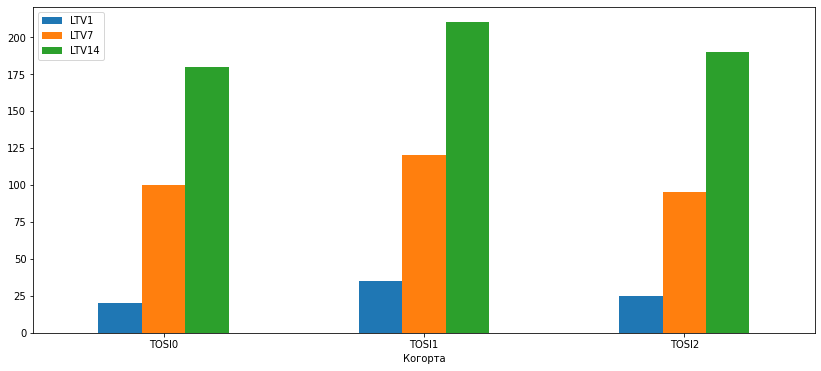

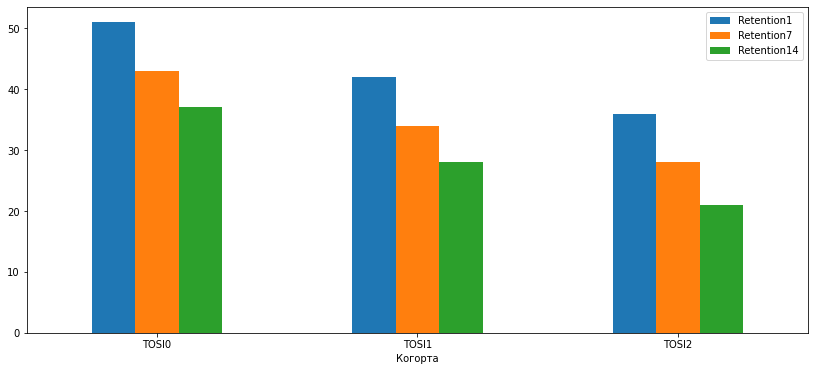

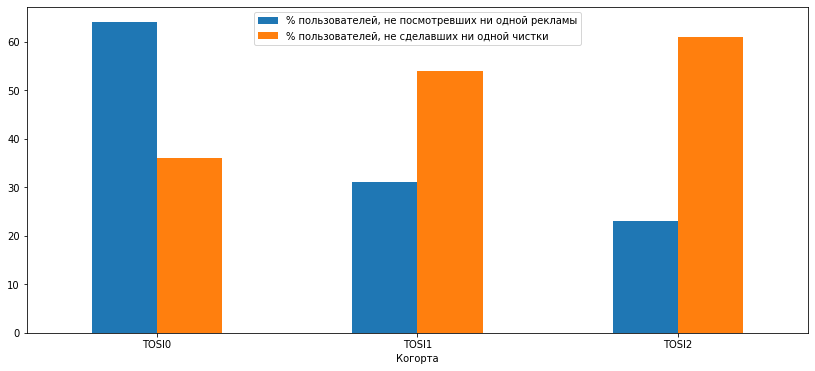

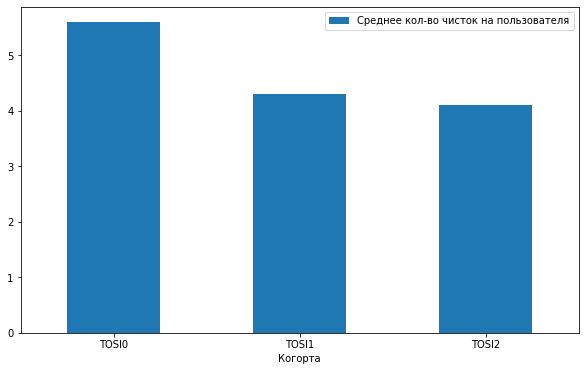

In [98]:
show_metrics_tosi(df_metrics)

In [100]:
df_adunit = pd.DataFrame([['TOSI0', 'adunit1', 56, 450554],
                          ['TOSI1', 'adunit1', 135, 1234023],
                          ['TOSI2', 'adunit1', 169, 1634056],
                          ['TOSI0', 'adunit2', 45, 360554],
                          ['TOSI1', 'adunit2', 123, 1124023],
                          ['TOSI2', 'adunit2', 148, 1414056],
                          ['TOSI0', 'adunit3', 11, 95675],
                          ['TOSI1', 'adunit3', 76, 356767],
                          ['TOSI2', 'adunit3', 85, 423576],
                          ['TOSI0', 'adunit4', 22, 156789],
                          ['TOSI1', 'adunit4', 96, 654786],
                          ['TOSI2', 'adunit4', 110, 856756],
                          ['TOSI0', 'adunit5', 67, 467898],
                          ['TOSI1', 'adunit5', 144, 1345678],
                          ['TOSI2', 'adunit5', 178, 1678978],],
                          columns=['cohort',
                                   'adunit',
                                   'avg_cnt_ad',
                                   'sum_cnt_ad'])            

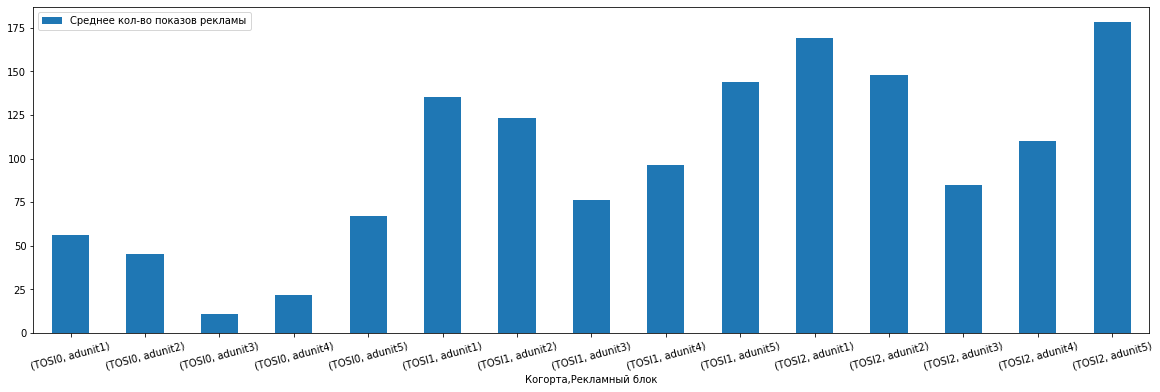

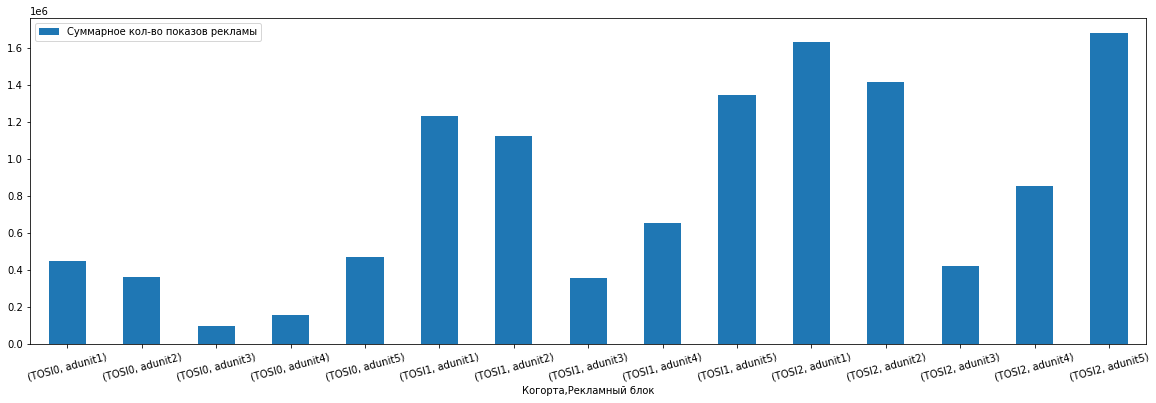

In [101]:
show_adunit_tosi(df_adunit)

4. Посмотреть на наше приложение и события аналитические за декабрь-январь и
попробовать на основе этих данных

    a. найти 2 “инсайта” (например, что юзеры на таком-то телефоне или такой-то
    версии несут больше LTV, чем другие)

    b. визуализировать воронки входа в наше приложение (от запуска до
    попадания на главный экран) в зависимости от одного из 4 сценариев (вход
    через иконку, вход через серверный пуш, вход через триггерный пуш, вход
    через виджет), где начало воронки - клик в иконку или пуш, а конец воронки
    - открытие главной страницы (по пути есть события, все они будут
    переданы)

        i. т.е. на выходе ожидаем для юзеров, установивших приложение с 1 по
        31 декабря увидеть их на горизонте от 1 до 30 января как они
        попадают в приложение в % от общего количества пользователей
        (например, на первый день 50% входят через виджет и 10% через
        пуш, а на 30-й день 10% через виджет и 40% через серверный пуш)

            1. если юзер входил в приложение в один день разными путями -
            мы считаем его несколько раз, таким образом, юзеров может
            быть более 100% по дню
Задача является ОПЦИОНАЛЬНОЙ! (не является обязательной и скорее является “бонус треком”, т.к. есть понимание, что она может быть бесконечно сложной)
- Для решения задачи нас интересует целая группа событий с префиксом ias_*
- Нас не интересуют пользователи, у которых нет ни одного события ias_hide_splash и у которых было в атрибуции tosi=1 или tosi=2 (из задачи 3)
- В каждом из этих событий есть в параметрах поле scenario, которое принимает следующие интересующие нас значения:
    - 1- вход через иконку
    - 10 - вход через серверный пуш
    - 6 - вход через триггерный пуш
    - 4 - вход через виджет
- Воронка событий выглядит примерно так (вначале не пишу ias_*, все события начинаются с этих волшебных 4 символов)
    - show_splash_on_create - вход на сплеш
    - load_started - старт прогрузки рекламы Interstitial after splash
    - showed или show_failed - можно считать концом этой воронки (реклама либо показана, либо нет)
- Дополнительно хотелось бы узнать, у какого % пользователей от всего количества не было ни разу показа рекламы после сплеша на основе следующих событий
    - load_failed_final - финальный фэил загрузки, больше попыток не будет
    - show_failed - ошибка показа рекламы после сплеша
    - showed - реклама успешно показана после сплеша

In [144]:
def get_query_ias() -> str:
   '''
   Формирование запроса, выводящего аналитические показатели по событиям ias
   '''

   # берем таблицы с 01.12.2022 по 31.01.2023
   days = [day_of_month for day_of_month in list(product(['2022'],['12'], [str(day).zfill(2) for day in range(1, 32)]))] +\
          [day_of_month for day_of_month in list(product(['2023'],['01'], [str(day).zfill(2) for day in range(1, 32)]))]

   base_query = """
                select user_pseudo_id
                     , event_name
                     , case when e.key = 'scenario'
                            then e.value.int_value
                       end as scenario
                     , count(*) as cnt
                  from `clean-cleaner-dae49.analytics_267738527.events_{year}{month}{day}` as t
                     , unnest(event_params) as e
                 where event_name like 'ias_%'
                group by 1, 2, 3
                """

   union_query = """"""
   for year, month, day in days:
      union_query += '\n union all\n' + base_query.format(year=year, month=month, day=day)
   union_query = union_query.lstrip('\n union all\n')

   filter_tosi_query = """
                       select distinct user_pseudo_id
                         from `clean-cleaner-dae49.analytics_267738527.events_{year}{month}{day}` as t
                        where traffic_source.name like '%|%|%|tosi1'
                           or traffic_source.name like '%|%|%|tosi2'
                        """

   union_tosi_query = """"""
   for year, month, day in days:
      union_tosi_query += '\n union\n' + filter_tosi_query.format(year=year, month=month, day=day)
   union_tosi_query = union_tosi_query.lstrip('\n union\n')   

   complete_query = f"""
               with union_query as ({union_query}),
                  
                    union_tosi_query as ({union_tosi_query}),

                    group_by_user as (
                     select uq.user_pseudo_id
                          , count(case when scenario = 1 then 1 end) as cnt_enter_icon
                          , count(case when scenario = 10 then 1 end) as cnt_enter_server_push
                          , count(case when scenario = 6 then 1 end) as cnt_enter_trigger_push
                          , count(case when scenario = 4 then 1 end) as cnt_enter_widget
                          , count(case when event_name = 'show_splash_on_create' then 1 end) as cnt_show_splash_on_create
                          , count(case when event_name = 'load_started' then 1 end) as cnt_load_started
                          , count(case when event_name = 'showed' then 1 end) as cnt_showed
                          , count(case when event_name = 'show_failed' then 1 end) as cnt_show_failed
                          , count(case when event_name = 'load_failed_final' then 1 end) as cnt_load_failed_final
                       from union_query uq
                        left join union_tosi_query utq
                         on uq.user_pseudo_id = utq.user_pseudo_id
                      where utq.user_pseudo_id is null
                     group by uq.user_pseudo_id
                     having max(case when event_name = 'ias_hide_splash' then 1 end) = 1)

               select round(100*sum(cnt_enter_icon)/count(distinct user_pseudo_id)) as enter_icon_percentage
                    , round(100*sum(cnt_enter_server_push)/count(distinct user_pseudo_id)) as server_push_percentage
                    , round(100*sum(cnt_enter_trigger_push)/count(distinct user_pseudo_id)) as trigger_push_percentage
                    , round(100*sum(cnt_enter_widget)/count(distinct user_pseudo_id)) as enter_widget_percentage
                    , round(100*sum(cnt_show_splash_on_create)/count(distinct user_pseudo_id)) as show_splash_on_create_percentage
                    , round(100*sum(cnt_load_started)/count(distinct user_pseudo_id)) as load_started_percentage
                    , round(100*sum(cnt_showed)/count(distinct user_pseudo_id)) as showed_percentage
                    , round(100*sum(cnt_show_failed)/count(distinct user_pseudo_id)) as show_failed_percentage
                    , round(100*sum(cnt_load_failed_final)/count(distinct user_pseudo_id)) as load_failed_final_percentage
                    , round(100*count(case when sum(cnt_showed) = 0 then 1 end)/count(distinct user_pseudo_id)) as ad_never_showed_percentage
                 from group_by_user
               """

   return complete_query

def show_funnel_ias(df: pd.DataFrame):
   '''
   Отображение воронки входа в приложение
   '''

   df = df.transpose().reset_index().rename(columns={'index': 'Уровень воронки', 0: 'Кол-во пользователей, %'})\
      .sort_values(by='Кол-во пользователей, %', ascending=False)\
      .replace({'trigger_push_percentage': 'Вход через триггерный пуш',
                'enter_widget_percentage': 'Вход через виджет',
                'enter_icon_percentage': 'Вход через иконку',
                'server_push_percentage': 'Вход через серверный пуш',
                'show_splash_on_create_percentage': 'Вход на сплеш',
                'load_started_percentage': 'Старт прогрузки рекламы',
                'showed_percentage': 'Реклама показана',
                'show_failed_percentage': 'Реклама не показана',
                'load_failed_final_percentage': 'Финальный фэйл загрузки',
                'ad_never_showed_percentage': 'Ни разу не было показа рекламы'})
   fig0 = px.funnel(df,
                  x='Кол-во пользователей, %',
                  y='Уровень воронки',
                  title='Воронка входа в приложение (Декабрь - Январь)', opacity=0.9)
   fig0.show()

In [140]:
query_ias = get_query_ias()

In [141]:
print(query_ias)


               with union_query as (select user_pseudo_id
                     , event_name
                     , case when e.key = 'scenario'
                            then e.value.int_value
                       end as scenario
                     , count(*) as cnt
                  from `clean-cleaner-dae49.analytics_267738527.events_20221201` as t
                     , unnest(event_params) as e
                 where event_name like 'ias_%'
                group by 1, 2, 3
                
 union all

                select user_pseudo_id
                     , event_name
                     , case when e.key = 'scenario'
                            then e.value.int_value
                       end as scenario
                     , count(*) as cnt
                  from `clean-cleaner-dae49.analytics_267738527.events_20221202` as t
                     , unnest(event_params) as e
                 where event_name like 'ias_%'
                group by 1, 2, 3
              

In [ ]:
# df_ias = client.query(query_ias).to_dataframe()

In [142]:
df_ias = pd.DataFrame([[45, 42, 56, 47, 33, 28, 19, 11, 8, 5]],
                       columns=['enter_icon_percentage',
                                'server_push_percentage',
                                'trigger_push_percentage',
                                'enter_widget_percentage',
                                'show_splash_on_create_percentage',
                                'load_started_percentage',
                                'showed_percentage',
                                'show_failed_percentage',
                                'load_failed_final_percentage',
                                'ad_never_showed_percentage'])            

In [145]:
show_funnel_ias(df_ias)